<a href="https://colab.research.google.com/github/katyasmpsn/thesis/blob/main/clusters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# only run the install line below if the kernel has re-started 
# !pip install transformers
import torch
import pandas as pd
from collections import Counter, defaultdict
from transformers import BertTokenizerFast, BertModel
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns

model = BertModel.from_pretrained('bert-base-uncased')
t = BertTokenizerFast.from_pretrained('bert-base-uncased')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# 🧹 Pre-Processing


---



The note text has been pre-cleaned locally due to the size of the raw JSON blob. See `thesis/dev/thesis-rough-work.ipynb` 

1.   usernames, hashtags, urls, stopwords, punctuation, and digits omitted
2.   Stop words removed 

**TO DO**: try without omitting stopwords. BERT might capture the "unnaturalness" of note text without stopwords 



In [5]:
df = pd.read_csv("/content/drive/MyDrive/Thesis/cleaned_data.csv")
"""creating a column with a list of words for each text snippet so that it's easier to to calculate term frequencies over the corpus"""
df['noteTextList'] = df['noteText'].str.lower().str.split()
df = df[~df['noteTextList'].isnull()]  # why are there empty notes at this point? 

# 🔢 Corpus Statistics 

Sia et al found that using term frequency as their corpus statistic worked best. I'll also use term frequency with their notation

tf $= \frac{n_{t}}{\Sigma_{t'}n_{t'}}$ where $n_{t}$ is the count of the word type $t$. 


In [6]:
# initializing Counter object 
vocab_counts = Counter()
# updating the counter 
df['noteTextList'].apply(vocab_counts.update)
corpus_denominator = sum(vocab_counts.values())
# tf weights 
vocab_counts = {key:value/corpus_denominator for (key,value) in vocab_counts.items()}

# 💽 Generate Word Type Embeddings

We get the last hidden state from BERT for each word token, using the entire note/tweet/reply as the context window. Then the embeddings are averaged over each word type. 



In [7]:
def getTokenEmbeddings(t1):
  """
  INPUT: full text 
  OUTPUT: dictionary with each tokens last hidden state. If the original token 
  was broken down into subwords, the average over subword representations is
  returned 

  {token : 1x768 vector}
  """

  # this is possibly bad coding, `t` and `model` were instantiated outside of this function
  # in the first code block 

  tokens = t(t1, return_attention_mask=False, return_token_type_ids=False)
  words_ids = tokens.word_ids() 

  encoded_input = t(t1, return_tensors='pt')
  output = model(**encoded_input)

  # Average subword representations 
  # Generate dummies for words_ids, multiply by the tensor
  wi_d = pd.get_dummies(pd.Series(words_ids)).T
  squeezed_states = torch.squeeze(output['last_hidden_state'])
  reduced_states = torch.matmul(torch.from_numpy(wi_d.values.astype('float32')), squeezed_states)

  words = t1.split()

  res = {words[i]: reduced_states[i] for i in range(len(words))}
  return res


In [8]:
fake_data = ["don't look up the comet can't be real", "look up everything is about to change because of the comet"]
fake = pd.DataFrame(fake_data, columns=["text"])

In [9]:
# df.tweetText.tolist()

In [10]:
text = fake.text.tolist()
# so this is iterating through a list of text strings, and list of dicts [{t1_tok1: embed, t1_tok2: embed},{t2_tok1: embed, t2_tok2: embed}] 
text = [getTokenEmbeddings(x) for x in text]

In [11]:
small_df = df.head(100)
strings = small_df.noteText.tolist() 
embeddings = [getTokenEmbeddings(x) for x in strings]

In [12]:
len(embeddings)

100

In [13]:
# just a toy function for now, but it's creating a master dictionary for the vocab. 
# in the example: "look" is used twice, and is in two separate dictionaries in `text`. 
# this adds all of the embeddings for "look" into one list
d = {}
for d_t in embeddings: 
  for k,v in d_t.items():
    try:
      if d[k]:
        d[k].append(v)
    except KeyError:
      d[k] = [v]

# this now averages all of the embeddings for tokens that have more than one

for k,v in d.items():
  if len(v) > 1:
    d[k] = [torch.mean(torch.stack(v), dim=0)]

In [14]:
# dumb unit test; make me into a function
for key in d.keys():
  if len(d[key][0]) != 768:
    print("wrong size embedding?")

# 🎆 Clustering

At this point, the object **d** has the averaged embeddings for each word type. It is a dictionary with word type keys and singleton lists with 1x768 tensors as values. 

Need to:
 

*   PCA to plot & match the paper's method
*   figure out the amount of topics for kmeans? elbow method? not sure what the paper used 


In [15]:
# detach takes out the grad requirement from the tensor

def detach_embedding(x):
  return x[0].detach().numpy()

embeddings = d.values()
embeddings = [detach_embedding(x) for x in embeddings]

In [16]:
X = pd.DataFrame(embeddings)

In [17]:
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,0.500943,-0.965443,1.173197,0.080457,-0.100670,-0.309771,-0.275647,-0.126112,-1.224885,0.289710,0.220474,-0.798529,-0.676313,1.039265,-0.802052,1.458760,-0.195792,-0.058395,-0.474813,0.849813,1.166793,-0.252264,-0.042450,0.683424,0.479201,-0.166501,0.500277,0.621496,-0.090702,0.913288,0.822156,-1.053345,-0.223252,-1.234302,0.738401,0.858072,-0.592779,-0.258400,-0.247093,-0.004976,...,-0.308149,-1.134255,0.115691,0.831924,-0.496194,-0.512290,-0.039780,0.154200,0.101781,-0.740516,-0.104814,-0.274520,0.602546,-0.218780,0.388895,-0.076223,-1.173910,-0.197265,-1.245872,0.807826,0.796667,-0.050560,-0.304900,-0.344170,0.930804,-0.610505,-0.094221,-0.482278,0.176575,-1.467923,-0.675851,1.225406,0.022615,0.201615,0.538386,0.198153,0.452605,-0.172506,0.217883,0.766335
1,0.063812,-0.166149,0.276012,-0.176552,0.261679,-0.290469,0.036751,-0.049440,-0.034774,-0.279499,0.018661,-0.629927,0.058792,0.221116,-1.189162,0.675285,-0.212695,0.190404,-0.160754,0.174557,0.116236,-0.359950,-0.100426,-0.439956,0.144025,0.012681,0.332056,-0.336896,-0.423590,-0.324017,0.370744,0.035391,0.647550,0.106608,-0.254535,0.241355,0.686207,-0.204107,-0.099655,0.428453,...,-0.568084,-0.431249,-0.583861,0.215799,-0.294502,-0.606923,-0.132053,0.431427,-0.011252,-0.426570,-0.413094,-0.051401,-0.526242,0.687292,-0.032888,0.288463,-0.516150,0.807288,0.061945,-0.178164,1.005292,0.379406,-0.832952,-0.167224,0.632475,0.037765,0.420715,-0.134621,0.279132,-0.496756,0.055511,-0.178638,0.493468,-0.405922,0.150884,-0.255865,0.310004,-0.672455,-0.307775,0.572541
2,-0.087828,0.066418,0.046834,-0.671555,0.455716,-0.323243,0.006974,0.356484,-0.077066,0.000464,0.119838,-0.231060,-0.284352,0.495985,-0.509845,0.711545,-0.584112,-0.473854,-0.075329,0.955073,-0.268778,-0.434422,1.028949,0.247688,0.718180,-0.215598,0.445579,0.640502,-0.513541,0.101455,0.864769,0.567417,0.925972,-0.313136,0.948132,-0.024099,0.028047,0.119517,-0.286386,-0.141679,...,-0.392993,-0.045361,-0.039154,0.647662,-0.511916,-0.435437,0.496035,0.279617,0.245628,-0.432948,-0.248736,0.452723,-0.174811,0.196678,-0.483367,0.029293,-0.004771,0.396548,-0.492204,0.273111,0.614156,0.541152,-0.231803,-0.141514,0.890441,-0.290440,-0.092247,0.053074,0.178527,-0.304930,-0.089771,0.269293,0.405772,-0.552942,0.466136,0.212748,0.200369,-0.667567,-0.516033,-0.636148
3,-0.220232,-0.160397,-0.248139,0.099729,0.185652,-0.110728,-0.228483,0.458076,0.491666,-0.102000,0.256094,-0.023791,-0.456628,-0.025701,0.282547,1.074631,0.271575,0.134694,-0.053919,0.237609,0.031594,-0.353012,0.363907,-0.194994,0.408867,0.041633,-0.184021,-0.301780,-0.404180,0.286125,0.642404,0.165943,0.293805,0.283870,-0.055504,-0.321653,-0.393500,0.733194,0.359375,-0.257693,...,-0.099335,-0.564539,-0.039955,-0.365677,-0.818883,0.083187,-0.472863,-0.207068,0.432335,-0.110115,-0.473273,0.392572,0.167136,0.350119,0.510845,0.373529,0.400193,0.912982,-0.821495,0.138908,-0.083800,0.411926,-0.324697,-0.431619,0.323056,-0.187387,0.277511,0.091765,-0.530368,-0.054088,-0.592423,0.356203,-0.060419,-0.295945,0.389739,0.011005,0.517617,-0.038284,0.186159,0.414151
4,0.074810,-0.078445,-0.161627,-0.057639,-0.081153,-0.030776,0.084072,-0.155454,0.660268,-0.749155,0.006340,-0.081877,0.014260,-0.125108,0.059869,0.004356,0.065728,-0.204256,0.056526,-0.516325,0.414022,0.424941,0.346446,-0.207526,-0.290422,-0.214262,0.513001,-0.036622,-0.108068,0.099109,0.526868,0.273404,0.226145,0.697800,-0.071017,-0.040982,-0.381138,0.050814,-0.452793,-0.143027,...,-0.479719,-0.719903,-0.052579,-0.362486,-0.764190,0.155463,-0.116463,0.533168,0.038176,0.112687,-0.724731,0.243003,0.301722,0.391564,-0.021255,-0.420009,0.149452,0.275167,0.300960,0.054418,0.718843,-0.084116,-0.906982,0.103714,0.320047,0.078567,0.225265,0.238599,-0.177

In [18]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# based on https://www.kaggle.com/minc33/visualizing-high-dimensional-clusters
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X)
clusters = kmeans.predict(X)
X["Cluster"] = clusters



In [19]:
plotX = X

In [20]:
# PCA

pca_2d = PCA(n_components=2)
PCs_2d = pd.DataFrame(pca_2d.fit_transform(plotX.drop(["Cluster"], axis=1)))
PCs_2d.columns = ["PC1_2d", "PC2_2d"]
plotX = pd.concat([plotX,PCs_2d], axis=1, join='inner')

cluster0 = plotX[plotX["Cluster"] == 0]
cluster1 = plotX[plotX["Cluster"] == 1]
cluster2 = plotX[plotX["Cluster"] == 2]


In [26]:
plotX.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,Cluster,PC1_2d,PC2_2d
0,0.500943,-0.965443,1.173197,0.080457,-0.100670,-0.309771,-0.275647,-0.126112,-1.224885,0.289710,0.220474,-0.798529,-0.676313,1.039265,-0.802052,1.458760,-0.195792,-0.058395,-0.474813,0.849813,1.166793,-0.252264,-0.042450,0.683424,0.479201,-0.166501,0.500277,0.621496,-0.090702,0.913288,0.822156,-1.053345,-0.223252,-1.234302,0.738401,0.858072,-0.592779,-0.258400,-0.247093,-0.004976,...,0.831924,-0.496194,-0.512290,-0.039780,0.154200,0.101781,-0.740516,-0.104814,-0.274520,0.602546,-0.218780,0.388895,-0.076223,-1.173910,-0.197265,-1.245872,0.807826,0.796667,-0.050560,-0.304900,-0.344170,0.930804,-0.610505,-0.094221,-0.482278,0.176575,-1.467923,-0.675851,1.225406,0.022615,0.201615,0.538386,0.198153,0.452605,-0.172506,0.217883,0.766335,0,4.303718,-1.104753
1,0.063812,-0.166149,0.276012,-0.176552,0.261679,-0.290469,0.036751,-0.049440,-0.034774,-0.279499,0.018661,-0.629927,0.058792,0.221116,-1.189162,0.675285,-0.212695,0.190404,-0.160754,0.174557,0.116236,-0.359950,-0.100426,-0.439956,0.144025,0.012681,0.332056,-0.336896,-0.423590,-0.324017,0.370744,0.035391,0.647550,0.106608,-0.254535,0.241355,0.686207,-0.204107,-0.099655,0.428453,...,0.215799,-0.294502,-0.606923,-0.132053,0.431427,-0.011252,-0.426570,-0.413094,-0.051401,-0.526242,0.687292,-0.032888,0.288463,-0.516150,0.807288,0.061945,-0.178164,1.005292,0.379406,-0.832952,-0.167224,0.632475,0.037765,0.420715,-0.134621,0.279132,-0.496756,0.055511,-0.178638,0.493468,-0.405922,0.150884,-0.255865,0.310004,-0.672455,-0.307775,0.572541,0,-0.831259,-1.357233
2,-0.087828,0.066418,0.046834,-0.671555,0.455716,-0.323243,0.006974,0.356484,-0.077066,0.000464,0.119838,-0.231060,-0.284352,0.495985,-0.509845,0.711545,-0.584112,-0.473854,-0.075329,0.955073,-0.268778,-0.434422,1.028949,0.247688,0.718180,-0.215598,0.445579,0.640502,-0.513541,0.101455,0.864769,0.567417,0.925972,-0.313136,0.948132,-0.024099,0.028047,0.119517,-0.286386,-0.141679,...,0.647662,-0.511916,-0.435437,0.496035,0.279617,0.245628,-0.432948,-0.248736,0.452723,-0.174811,0.196678,-0.483367,0.029293,-0.004771,0.396548,-0.492204,0.273111,0.614156,0.541152,-0.231803,-0.141514,0.890441,-0.290440,-0.092247,0.053074,0.178527,-0.304930,-0.089771,0.269293,0.405772,-0.552942,0.466136,0.212748,0.200369,-0.667567,-0.516033,-0.636148,0,-1.700248,-0.099840
3,-0.220232,-0.160397,-0.248139,0.099729,0.185652,-0.110728,-0.228483,0.458076,0.491666,-0.102000,0.256094,-0.023791,-0.456628,-0.025701,0.282547,1.074631,0.271575,0.134694,-0.053919,0.237609,0.031594,-0.353012,0.363907,-0.194994,0.408867,0.041633,-0.184021,-0.301780,-0.404180,0.286125,0.642404,0.165943,0.293805,0.283870,-0.055504,-0.321653,-0.393500,0.733194,0.359375,-0.257693,...,-0.365677,-0.818883,0.083187,-0.472863,-0.207068,0.432335,-0.110115,-0.473273,0.392572,0.167136,0.350119,0.510845,0.373529,0.400193,0.912982,-0.821495,0.138908,-0.083800,0.411926,-0.324697,-0.431619,0.323056,-0.187387,0.277511,0.091765,-0.530368,-0.054088,-0.592423,0.356203,-0.060419,-0.295945,0.389739,0.011005,0.517617,-0.038284,0.186159,0.414151,0,-3.473603,0.378097
4,0.074810,-0.078445,-0.161627,-0.057639,-0.081153,-0.030776,0.084072,-0.155454,0.660268,-0.749155,0.006340,-0.081877,0.014260,-0.125108,0.059869,0.004356,0.065728,-0.204256,0.056526,-0.516325,0.414022,0.424941,0.346446,-0.207526,-0.290422,-0.214262,0.513001,-0.036622,-0.108068,0.099109,0.526868,0.273404,0.226145,0.697800,-0.071017,-0.040982,-0.381138,0.050814,-0.452793,-0.143027,...,-0.362486,-0.764190,0.155463,-0.116463,0.533168,0.038176,0.112687,-0.724731,0.243003,0.301722,0.391564,-0.021255,-0.420009,0.149452,0.275167,0.300960,0.054418,0.718843,-0.084116,-0.906982,0.103714,0.320047,0.078567,0.225265,0.238599,-0.177281,-0.643222,0.057372,-0.035384,-0.176507,-0.023362,

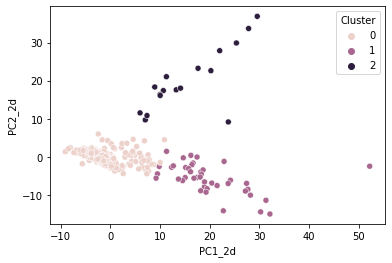

In [27]:
sns.scatterplot(data=plotX, x="PC1_2d", y="PC2_2d", hue="Cluster")


# bad plots ™